In [1]:
#IMPORTAZIONI E PARAMETRI DI BASE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

#CARICAMENTO DATI DI TRAINING
df_train = pd.read_csv('settimana_normale.csv')
df_train['datetime'] = pd.to_datetime(df_train['Timestamp'])
df_train.set_index('datetime', inplace=True)

# Feature
df_train['hour'] = df_train.index.hour
df_train['dayofweek'] = df_train.index.dayofweek
df_train['dT'] = df_train['Temperatura (°C)'].diff()
df_train['dT_long'] = df_train['Temperatura (°C)'].diff(periods=5)
df_train['SMA_3'] = df_train['Temperatura (°C)'].rolling(window=3).mean()
df_train.dropna(inplace=True) #rimuove tutte le righe contenenti valori NaN (Not a Number)

features = ['Temperatura (°C)', 'dT_long', 'dT', 'hour', 'SMA_3']
X_train = df_train[features]


In [2]:
#CARICAMENTO DATI DI TEST
df = pd.read_csv('anomalia_spike.csv')
df['datetime'] = pd.to_datetime(df['Timestamp'])
df.set_index('datetime', inplace=True)

# Feature engineering su test set
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dT'] = df['Temperatura (°C)'].diff()
df['dT_long'] = df['Temperatura (°C)'].diff(periods=5)
df['SMA_3'] = df['Temperatura (°C)'].rolling(window=3).mean()
df.dropna(inplace=True) #muovere tutte le righe contenenti valori NaN (Not a Number)
features_2 = ['Temperatura (°C)', 'dT_long', 'dT', 'hour', 'SMA_3']

X_test = df[features_2]

In [3]:
#ALLENAMENTO E PREDIZIONE
#model = IsolationForest(contamination=0.25, random_state=42)
#model.fit(X_train)
#df['anomaly_score'] = model.predict(X_test)
#df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


In [4]:
#metodo delle Bisezione per determinare il valore di contaminatione per cui si hanno 0 anomalie.
success = False
# Intervallo iniziale di ricerca
low = 1e-20
high = 1e-10
best_contamination = None

# Precisione desiderata
tolerance = 1e-20

while high - low > tolerance:
    mid = (low + high) / 2
    model = IsolationForest(contamination=mid, random_state=42)
    model.fit(X_train)
    
    df['anomaly_score'] = model.predict(X_train)
    df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)
    num_anomalies = df['anomaly'].sum()
    
    #print(f"Contamination: {mid:.20f}, Anomalie trovate: {num_anomalies}")
    
    if num_anomalies == 0:
        best_contamination = mid
        low = mid  # Prova valori più grandi
        success = True
    else:
        high = mid  # Troppo alto, prova valori più piccoli

if not success:
    raise Exception("Impossibile fittare il modello con zero anomalie.")
else:
    print(f"\n Contamination massimo con zero anomalie: {best_contamination:.20f}")



 Contamination massimo con zero anomalie: 0.00000000000000006743


In [5]:
    #ALLENAMENTO
 #   succes=False
#    for contamination in [1e-17]: #0.25,0.05, 0.006, 0.001, 0.0005]:
#       model = IsolationForest(contamination=contamination, random_state=42)
#        model.fit(X_train)
#        df['anomaly_score'] = model.predict(X_train)
#        df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)
#    
#        num_anomalies = df['anomaly'].sum()
 #       print(f"Contamination: {contamination}, Anomalie trovate: {num_anomalies}")
  #  
   #     if num_anomalies in [0]:
    #        succes = True
     #       break
    
        #if df[anomaly] ha 0 oppure 1 anomalia: 
            #succes=True
            #break
    
#    if not succes: 
 #           raise Exception ("Impossibile fittare il modello.")

In [6]:
#DATI "PULITI"
final_model = IsolationForest(contamination=best_contamination, random_state=42)
final_model.fit(X_train)
df_train['anomaly_score'] = final_model.predict(X_train)
df_train['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


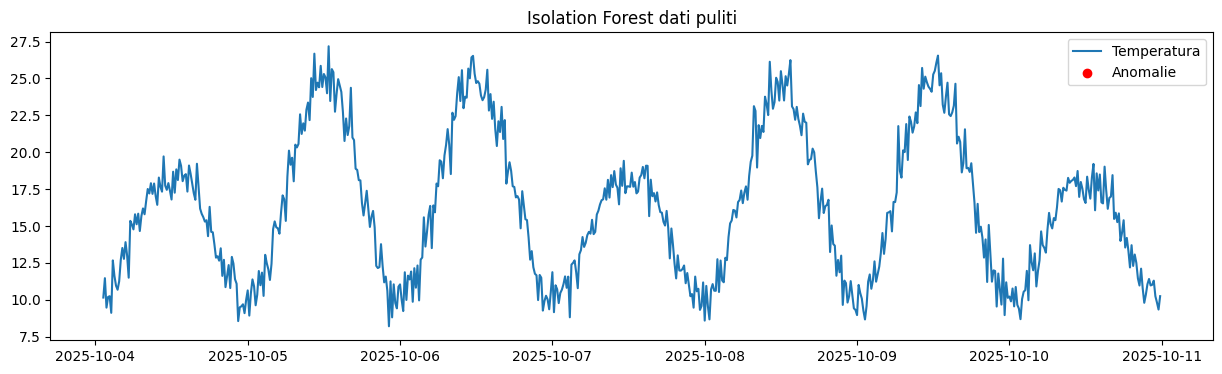

In [12]:
# Visualizzazione su serie temporale
plt.figure(figsize=(15, 4))
plt.plot(df_train.index, df_train['Temperatura (°C)'], label='Temperatura')
plt.scatter(df_train[df_train['anomaly'] == 1].index,
            df_train[df_train['anomaly'] == 1]['Temperatura (°C)'],
            color='red', label='Anomalie')
plt.legend()
plt.title("Isolation Forest dati puliti")
plt.show()

In [8]:
#PREDIZIONE - DATI CN ANOMALIE
df['anomaly_score'] = model.predict(X_test)
df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


In [9]:
#print("Predizioni su train? ", hasattr(df_train, 'anomaly_score'))
#print("Predizioni su test? ", hasattr(df, 'anomaly_score'))

# Esempio di risultati
print("Anomalie trovate (test):", df['anomaly'].sum())

Anomalie trovate (test): 2


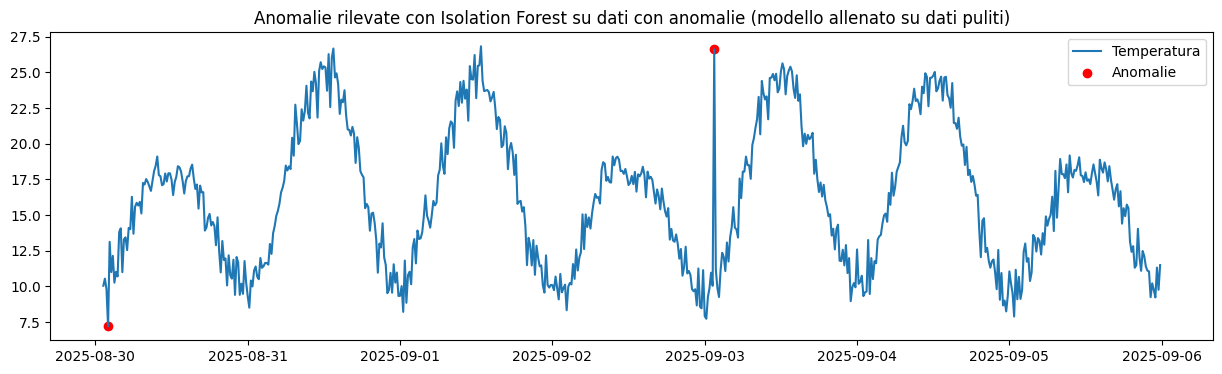

In [10]:
#Visualizzazione su serie temporale
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['Temperatura (°C)'], label='Temperatura')
plt.scatter(df[df['anomaly'] == 1].index,
            df[df['anomaly'] == 1]['Temperatura (°C)'],
            color='red', label='Anomalie')
plt.legend()
plt.title("Anomalie rilevate con Isolation Forest su dati con anomalie (modello allenato su dati puliti)")
plt.show()

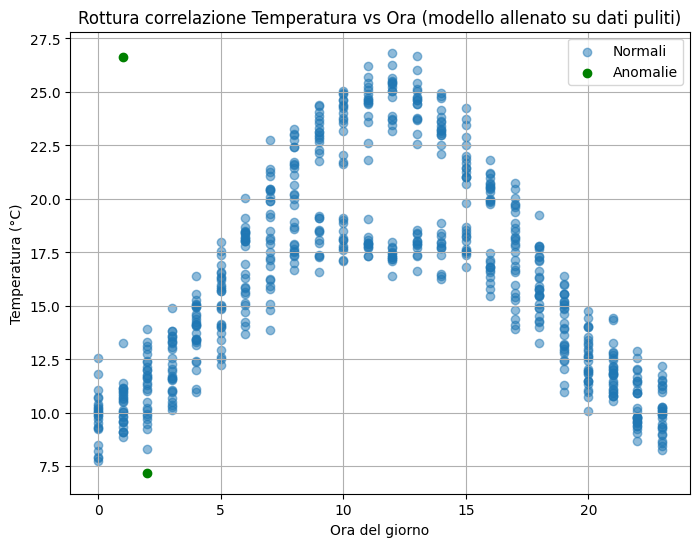

In [11]:
#Scatter plot per visualizzare rottura correlazione Temperatura - ora
normal = df[df['anomaly'] == 0]
anomaly = df[df['anomaly'] == 1]

plt.figure(figsize=(8, 6))
plt.scatter(normal['hour'], normal['Temperatura (°C)'], label='Normali', alpha=0.5)
plt.scatter(anomaly['hour'], anomaly['Temperatura (°C)'], color='green', label='Anomalie')
plt.xlabel('Ora del giorno')
plt.ylabel('Temperatura (°C)')
plt.title('Rottura correlazione Temperatura vs Ora (modello allenato su dati puliti)')
plt.legend()
plt.grid(True)
plt.show()